# FinTechProject - 5y Financial Planning of 3 Portfolios

In [32]:
# Initial imports
import os
import json
import requests
import pandas as pd
import numpy as np 
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from pathlib import Path
import panel as pn
from panel.interact import interact
import plotly.express as px
pn.extension("plotly")
import hvplot.pandas
from empyrial import empyrial, Engine
import dataframe_image as dfi  

%matplotlib inline

In [21]:
# Load .env enviroment variables
load_dotenv()

True

In [22]:
#access alpaca api
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [23]:
# Format current date as ISO format
start_date = pd.Timestamp("2012-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-04-25", tz="America/New_York").isoformat()

# Set the tickers
tickers = ['GOLD', 'WFG', 'IP', 'ASA', 'CMC', 'AAPL', 'XOM', 'AGG', 'JPM', 'PHM', 'AMZN', 'TSLA', 'GOOG', 'MSFT']

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start= start_date,
    end= end_date
).df

# Reorganize the DataFrame
# Separate ticker data
GOLD = df_portfolio[df_portfolio['symbol']== 'GOLD'].drop('symbol', axis=1)
WFG = df_portfolio[df_portfolio['symbol']== 'WFG'].drop('symbol', axis=1)
IP = df_portfolio[df_portfolio['symbol']== 'IP'].drop('symbol', axis=1)
ASA = df_portfolio[df_portfolio['symbol']== 'ASA'].drop('symbol', axis=1)
CMC = df_portfolio[df_portfolio['symbol']== 'CMC'].drop('symbol', axis=1)
AAPL = df_portfolio[df_portfolio['symbol']== 'AAPL'].drop('symbol', axis=1)
XOM = df_portfolio[df_portfolio['symbol']== 'XOM'].drop('symbol', axis=1)
AGG = df_portfolio[df_portfolio['symbol']== 'AGG'].drop('symbol', axis=1)
JPM = df_portfolio[df_portfolio['symbol']== 'JPM'].drop('symbol', axis=1)
PHM = df_portfolio[df_portfolio['symbol']== 'PHM'].drop('symbol', axis=1)
TSLA = df_portfolio[df_portfolio['symbol']== 'TSLA'].drop('symbol', axis=1)
AMZN = df_portfolio[df_portfolio['symbol']== 'AMZN'].drop('symbol', axis=1)
GOOG = df_portfolio[df_portfolio['symbol']== 'GOOG'].drop('symbol', axis=1)
MSFT = df_portfolio[df_portfolio['symbol']== 'MSFT'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames and create the 3 portfolios w/ weightings
will_investment_portfolio = pd.concat([GOLD, WFG, IP, ASA, CMC], axis=1, keys=['GOLD', 'WFG', 'IP', 'ASA', 'CMC'])
will_weightings = [0.2, 0.2, 0.2, 0.2, 0.2]
sam_investment_portfolio = pd.concat([AAPL, XOM, AGG, JPM, PHM], axis=1, keys=['AAPL', 'XOM', 'AGG', 'JPM', 'PHM'])
sam_weightings = [0.40, 0.2, 0.15, 0.1, 0.15]
gokhan_investment_portfolio = pd.concat([AAPL, TSLA, AMZN, GOOG, MSFT], axis=1, keys=['AAPL', 'TSLA', 'AMZN', 'GOOG','MSFT'])
gokhan_weightings =  [0.2, 0.3, 0.1, 0.1, 0.3]

# Preview one DataFrame
sam_investment_portfolio.head()

AAPL                                    \
                             open    high     low   close    volume   
timestamp                                                             
2015-12-01 05:00:00+00:00  118.73  118.81  116.86  117.34  34852374   
2015-12-02 05:00:00+00:00  117.00  118.11  116.08  116.28  33385643   
2015-12-03 05:00:00+00:00  116.55  116.79  114.22  115.20  41560785   
2015-12-04 05:00:00+00:00  115.20  119.25  115.11  119.03  57776977   
2015-12-07 05:00:00+00:00  118.98  119.86  117.81  118.28  32080754   

                                                     XOM                  ...  \
                          trade_count        vwap   open   high      low  ...   
timestamp                                                                 ...   
2015-12-01 05:00:00+00:00      187129  117.756760  81.95  82.13  81.2700  ...   
2015-12-02 05:00:00+00:00      180616  117.151198  81.36  81.64  79.4200  ...   
2015-12-03 05:00:00+00:00      245330  115.434888  79.80  79.85  78.0200  ...   
2015-12-04 05:00:00+00:00      307788  118.187290  77.45  78.98  77.0335  ...   
2015-12-07 05:00:00+00:00      190809  118.509111  77.35  77.50  75.7500  ...   

                                JPM                           PHM          \
                             volume trade_count       vwap   open    high   
timestamp                                                                   
2015-12-01 05:00:00+00:00  12708809       77160  67.407119  19.55  19.700   
2015-12-02 05:00:00+00:00  13440883       82202  67.002375  19.66  19.700   
2015-12-03 05:00:00+00:00  14626881       93602  66.213768  19.20  19.250   
2015-12-04 05:00:00+00:00  17786143      103719  67.491175  19.01  19.460   
2015-12-07 05:00:00+00:00  11701751       77152  66.895082  19.33  19.515   

                                                                           
                               low  close   volume trade_count       vwap  
timestamp                                                                  
2015-12-01 05:00:00+00:00  19.3400  19.65  3817724       21885  19.551376  
2015-12-02 05:00:00+00:00  18.9400  19.08  6428563       29857  19.195611  
2015-12-03 05:00:00+00:00  18.7399  18.89  5517055       28055  18.967152  
2015-12-04 05:00:00+00:00  18.8800  19.42  4003215       23726  19.269375  
2015-12-07 05:00:00+00:00  19.2300  19.38  3123001       19311  19.352605  

[5 rows x 35 columns]

In [50]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
#weightings and the securities are defined above and the number of simulations = 500
Sam_MC_5year = MCSimulation(
    portfolio_data = sam_investment_portfolio,
    weights = sam_weightings,
    num_simulation = 500,
    num_trading_days = 252*5
)
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
Sam_MC_5year.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.982301,1.002519,0.994531,0.993869,1.006226,1.000294,1.007897,1.018087,0.991147,1.002569,...,1.009608,1.001867,0.994723,0.996035,0.990408,1.006719,0.991572,0.991670,1.007236,0.998678
2,0.989973,0.980219,0.994404,1.005709,1.018277,1.002021,1.015704,1.021550,0.999918,0.986309,...,0.995360,0.985544,0.985175,0.989025,0.995189,1.004341,0.980383,0.989994,1.013490,0.983943
3,1.001786,0.960785,1.013429,1.013192,1.001133,1.005318,1.033984,0.989484,0.973529,0.978580,...,1.017002,0.994190,0.971131,0.981256,1.011883,0.981780,0.954469,0.980739,1.006574,0.983025
4,1.014285,0.960876,1.006253,1.007391,1.000795,0.999227,1.041424,0.989034,0.978762,0.976180,...,1.001819,0.987182,0.965820,0.975930,1.016989,0.951778,0.972547,0.971522,1.016813,0.974469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.903520,0.622473,1.906114,1.522561,1.294867,0.749614,5.942385,2.147470,2.385975,1.893244,...,0.944014,1.177321,1.124028,1.391454,1.898504,3.374188,2.227150,0.618577,2.689089,1.331089
1257,1.908761,0.631369,1.907001,1.526424,1.318371,0.756463,5.892902,2.155046,2.319626,1.891128,...,0.941528,1.162818,1.122178,1.408641,1.924029,3.396786,2.222650,0.619958,2.679741,1.315433
1258,1.932347,0.626911,1.928218,1.556624,1.337131,0.747310,5.659141,2.125006,2.285084,1.870020,...,0.937635,1.174362,1.135082,1.420908,1.901494,3.399462,2.195058,0.617557,2.668416,1.320399
1259,1.918763,0.621245,1.924740,1.554131,1.355625,0.776008,5.650643,2.137257,2.285412,1.881531,...,0.935168,1.179207,1.143870,1.418808,1.902846,3.334745,2.204919,0.615788,2.646136,1.286530


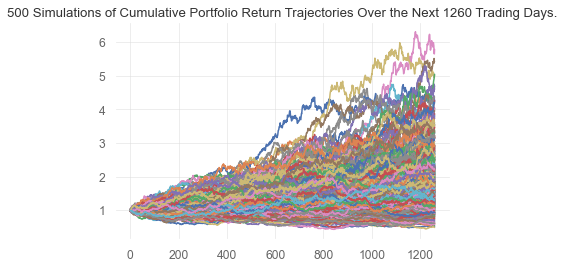

In [51]:
# Plot simulation outcomes
sam_line_plot = Sam_MC_5year.plot_simulation()

# Save the plot for future usage
sam_line_plot.get_figure().savefig("Sam_MC_5year_sim_plot.png", bbox_inches="tight")


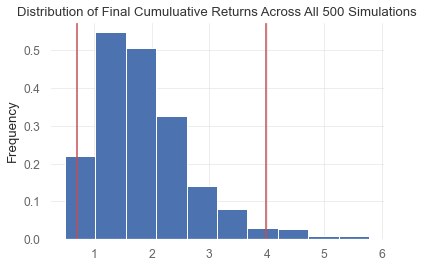

In [52]:
# Plot probability distribution and confidence intervals
sam_dist_plot = Sam_MC_5year.plot_distribution()

# Save the plot for future usage
sam_dist_plot.get_figure().savefig('Sam_MC_5year_dist_plot.png',bbox_inches='tight')


In [53]:
# Fetch summary statistics from the Monte Carlo simulation results

sams_tbl = Sam_MC_5year.summarize_cumulative_return()

# Print summary statistics
sams_tbl

#dfi.export(sams_stat_df, "sams_stats.png")

count           500.000000
mean              1.863284
std               0.826801
min               0.486346
25%               1.272004
50%               1.720887
75%               2.256542
max               5.781423
95% CI Lower      0.701348
95% CI Upper      3.991761
Name: 1260, dtype: float64

In [54]:
initial_investment_100k = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $100,000
ci_lower_100k = sams_tbl[8] * initial_investment_100k
ci_upper_100k = sams_tbl[9] * initial_investment_100k

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_100k:,.2f} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_100k:,.2f} and ${ci_upper_100k:,.2f}")

There is a 95% chance that an initial investment of $100,000.00 in the portfolio over the next 5 years will end within in the range of $70,134.82 and $399,176.10


In [55]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
#weightings and the securities are defined above and the number of simulations = 500
Will_MC_5year = MCSimulation(
    portfolio_data = will_investment_portfolio,
    weights = will_weightings,
    num_simulation = 500,
    num_trading_days = 252*5
)

Will_MC_5year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.007933,0.986576,0.997074,0.989403,0.988466,0.991189,0.998076,0.993012,0.986514,1.005175,...,0.975585,0.983518,0.995187,0.993947,1.006449,1.007833,1.025420,1.003113,1.005470,0.983337
2,1.005960,0.970220,1.003567,0.998307,0.999021,0.998697,1.001778,1.005627,0.970303,1.020066,...,0.982427,1.001231,0.985980,0.993055,1.018589,1.007124,1.033161,0.993756,1.006779,0.965685
3,1.011709,0.980026,0.984420,0.999937,0.996410,1.013865,0.987862,1.002430,0.965143,1.022687,...,0.973625,0.991831,0.973558,1.009514,1.014984,1.027706,1.052330,0.991674,0.998923,0.975330
4,1.010393,1.003881,1.000759,1.020495,1.004378,1.009441,0.985622,0.997047,0.976661,1.015801,...,0.959647,0.998226,0.980244,0.996455,1.018779,1.039336,1.056085,1.000552,1.008934,0.994822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,3.602857,3.276236,1.458810,2.800036,2.034933,1.141669,0.978630,2.413836,1.885834,3.513340,...,1.402013,1.430006,2.695440,2.262506,3.505581,2.503678,2.161912,2.884806,1.605709,2.320128
1257,3.548764,3.289000,1.487249,2.839274,2.025258,1.134355,0.976562,2.404366,1.908454,3.489476,...,1.401766,1.435750,2.729987,2.263082,3.584897,2.510386,2.147931,2.879529,1.605184,2.313514
1258,3.573495,3.266065,1.499953,2.819510,1.997923,1.134767,0.995850,2.397231,1.927855,3.396740,...,1.409610,1.437021,2.732705,2.231883,3.579264,2.520571,2.169096,2.859946,1.643024,2.293453
1259,3.597724,3.275876,1.481171,2.806386,2.020487,1.121698,0.993668,2.396896,1.905008,3.405223,...,1.404763,1.414981,2.794195,2.228949,3.557596,2.462291,2.111959,2.926472,1.640480,2.276029


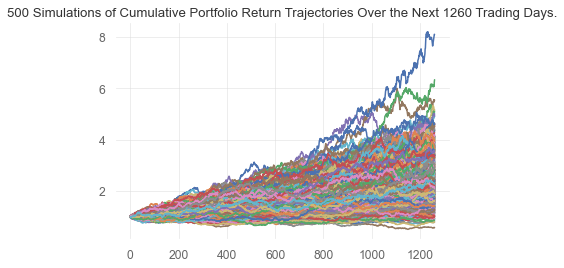

In [56]:
# Plot probability distribution and confidence intervals
will_line_plot = Will_MC_5year.plot_simulation()

# Save the plot for future usage
will_line_plot.get_figure().savefig("Will_MC_5year_sim_plot.png", bbox_inches="tight")

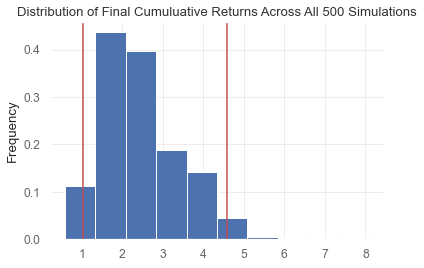

In [57]:
# Plot probability distribution and confidence intervals
will_dist_plot = Will_MC_5year.plot_distribution()

# Save the plot for future usage
will_dist_plot.get_figure().savefig('Will_MC_5year_dist_plot.png',bbox_inches='tight')

In [58]:
# Fetch summary statistics from the Monte Carlo simulation results

wills_tbl = Will_MC_5year.summarize_cumulative_return()

# Print summary statistics
wills_tbl

#dfi.export(sams_stat_df, "sams_stats.png")

count           500.000000
mean              2.457646
std               0.973699
min               0.580093
25%               1.719829
50%               2.289937
75%               3.027335
max               8.093231
95% CI Lower      1.027683
95% CI Upper      4.594538
Name: 1260, dtype: float64

In [59]:
will_initial_investment_100k = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $100,000
will_ci_lower_100k = wills_tbl[8] * initial_investment_100k
will_ci_upper_100k = wills_tbl[9] * initial_investment_100k

# Print results
print(f"There is a 95% chance that an initial investment of ${will_initial_investment_100k:,.2f} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${will_ci_lower_100k:,.2f} and ${will_ci_upper_100k:,.2f}")

There is a 95% chance that an initial investment of $100,000.00 in the portfolio over the next 5 years will end within in the range of $102,768.30 and $459,453.82


In [60]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
#weightings and the securities are defined above and the number of simulations = 500
Gokhan_MC_5year = MCSimulation(
    portfolio_data = gokhan_investment_portfolio,
    weights = gokhan_weightings,
    num_simulation = 500,
    num_trading_days = 252*5
)
Gokhan_MC_5year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006700,0.976835,1.010375,0.986000,1.002239,0.996283,1.002785,1.023705,0.985344,1.016997,...,0.990155,0.994535,0.994747,0.999392,1.004584,1.013999,0.988665,0.987668,1.007522,0.992101
2,1.009890,0.975562,0.998520,0.989964,1.022051,0.997204,1.012344,1.012405,0.997136,1.003957,...,0.991483,0.992737,0.998140,0.998175,1.019496,1.009001,0.997618,1.007449,1.007548,0.977327
3,1.009883,0.985061,0.961262,1.014308,1.028651,0.977460,1.012435,1.025068,1.000187,0.993106,...,0.997360,0.982410,0.980774,0.959367,1.016217,1.006032,0.981573,1.004610,1.017405,1.014323
4,1.017103,1.002688,0.946096,1.020747,1.016957,0.978908,0.997714,1.041431,1.033793,0.988314,...,1.009109,1.006230,1.013760,0.983472,1.020886,0.974669,0.988006,0.991379,1.014129,1.012018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,6.101815,7.078974,2.682957,3.632511,4.621880,3.522799,7.542579,6.555174,3.551740,3.662361,...,8.938896,5.420306,6.386786,2.441786,3.891294,3.032307,2.939649,4.141427,1.021653,10.549702
1257,6.108656,7.066492,2.734191,3.757533,4.582452,3.599014,7.502876,6.568675,3.554680,3.502156,...,8.897014,5.438676,6.451208,2.511461,3.963811,2.964104,3.044494,4.161687,1.024106,10.808532
1258,6.211043,7.195912,2.699948,3.723138,4.681199,3.672912,7.447720,6.635015,3.619929,3.584089,...,8.969240,5.570383,6.636602,2.524389,3.956168,2.937857,3.096958,4.177400,1.055259,10.892797
1259,6.220336,7.222952,2.721719,3.715420,4.681636,3.747309,7.545952,6.742367,3.639139,3.519845,...,8.966799,5.519098,6.652326,2.466636,3.964506,2.923877,3.074933,4.212761,1.039063,10.599690


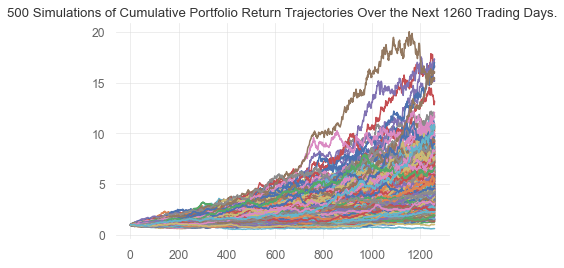

In [62]:
# Plot probability distribution and confidence intervals
gokhan_line_plot = Gokhan_MC_5year.plot_simulation()

# Save the plot for future usage
gokhan_line_plot.get_figure().savefig("Gokhan_MC_5year_sim_plot.png", bbox_inches="tight")

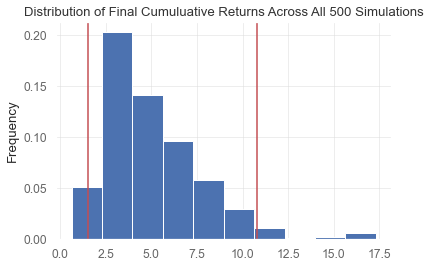

In [63]:
# Plot probability distribution and confidence intervals
gokhan_dist_plot = Gokhan_MC_5year.plot_distribution()

# Save the plot for future usage
gokhan_dist_plot.get_figure().savefig('Gokhan_MC_5year_dist_plot.png',bbox_inches='tight')

In [64]:
# Fetch summary statistics from the Monte Carlo simulation results

gokhans_tbl = Gokhan_MC_5year.summarize_cumulative_return()

# Print summary statistics
gokhans_tbl

#dfi.export(sams_stat_df, "sams_stats.png")

count           500.000000
mean              5.090422
std               2.660385
min               0.633300
25%               3.291219
50%               4.473372
75%               6.322945
max              17.304050
95% CI Lower      1.536352
95% CI Upper     10.766435
Name: 1260, dtype: float64

In [65]:
gokhan_initial_investment_100k = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $100,000
gokhan_ci_lower_100k = gokhans_tbl[8] * initial_investment_100k
gokhan_ci_upper_100k = gokhans_tbl[9] * initial_investment_100k

# Print results
print(f"There is a 95% chance that an initial investment of ${gokhan_initial_investment_100k:,.2f} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${gokhan_ci_lower_100k:,.2f} and ${gokhan_ci_upper_100k:,.2f}")

There is a 95% chance that an initial investment of $100,000.00 in the portfolio over the next 5 years will end within in the range of $153,635.22 and $1,076,643.49
